## Final Project Submission

* Student name: **Ru Keïn**
* Student pace: **Full-Time**
* Scheduled project review date/time: 
* Instructor name: **James Irving, PhD**
* Blog post URL:


---
# Obtain
* Import requisite libraries and data
* Inspect columns, dataypes
    * df.head()

In [85]:
# import PyPi package for cohort libraries using shortcut
#!pip install -U fsds_100719 # comment out after install so it won't run again

In [86]:
import fsds_100719 as fs
from fsds_100719.imports import *
plt.style.use('seaborn')
#inline_rc = dict(mpl.rcParams)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest as normtest # D'Agostino and Pearson's omnibus test
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [87]:
#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')

# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

In [88]:
# import dataset
df = pd.read_csv('kc_house_data.csv') 
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


---
### Column Names and descriptions for Kings County Data Set

#### SET_INDEX
* **id** - unique identified for a house

#### TARGET
* **pricePrice** -  is prediction target

#### DATETIME
* **dateDate** - house was sold
* **yr_built** - Built Year

#### BOOL
* **yr_renovated** - Year when house was renovated
* **waterfront** - House which has a view to a waterfront

#### CONTINUOUS
* **sqft_livingsquare** -  footage of the home
(drop or combine with sqft_living if both == higher coef)
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors
* **sqft_lotsquare** -  footage of the lot
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement


#### CATEGORICAL

* **grade** - overall grade given to the housing unit, based on King County grading system
(drop bc or multicollinearity - or combine with grade if higher coef)
* **condition** - How good the condition is ( Overall )
* **bathroomsNumber** -  of bathrooms/bedrooms
* **bedroomsNumber** -  of Bedrooms/House
* **floorsTotal** -  floors (levels) in house
* **view** - Has been viewed

* **zipcode** - zip
(drop - redundant with zipcode)
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
---

---
# SCRUB 

## Scrub 1 : categorizing / casting data types

**Q1: Which predictors should be analyzed as continuous data, vs binned/categorical data?**

+ preliminary analysis, data casting, and visualizations
+ check for linearity, normal distributions

### Review initial data summaries

       * Check and cast data types
               * df.info()
               * df.set_index()
               * df.unique()
               * df.isna().sum()
               * df.describe()
               * df.min(), .max()
               * df.value_counts()
          

#### Display Info  

In [107]:
# Display information about the variables, columns and datatypes
# The raw dataset contains 2 objects: 'date', 'sqft_basement'
# dtypes: float64(8), int64(11), object(2)
  
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(2)
memory usage: 3.5+ MB


#### Set dataframe index to 'id'

In [90]:
df.set_index('id', inplace=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Null / Missing Values

##### Scrub  1 : Null / Missing Values

**Q2: How do we deal with missing values?**
 
+ remove null values
+ recast data types

          * Drop null rows or columns as appropriate
              * df.isna().sum()
              * df.drop()
              * df.drop(['col1','col2'],axis=1)
                  * drop sqft_basement
          
          * Coarse Binning NUMERICAL Data
              * replace with median or bin/convert to categorical
                   * bin yr_built
                   * bin sqft_basement
                   * bin sqft_above
          
          * CATEGORICAL data: 
              * make NaN own category OR replace with most common category
              * Fill in null values and recast variables for EDA
                   * zipcode --> coded
                   * View --> category
                   * Waterfront --> boolean
                   * yr_renovated --> is_reno (boolean)


In [94]:
# (1) Identify Null and placeholder values
def find_nulls(df):
    print(f"Columns with Null Values")
    print("------------------------")
    for column in df:
        if df[column].isna().sum() > 0:
            print(f"{df[column].name}: \n{df[column].isna().sum()} out of {len(df[column])} ({round(df[column].isna().sum()/len(df[column])*100,2)}%)\n")

find_nulls(df)            

Columns with Null Values
------------------------
waterfront: 
2376 out of 21597 (11.0%)

view: 
63 out of 21597 (0.29%)

yr_renovated: 
3842 out of 21597 (17.79%)



#### ['waterfront']

In [136]:
def summarizer(data, column):
    print(f"\n{data[column].name.upper()}")
    print("-"*len(data[column].name))
    print(f"Nulls\n{df[column].isna().sum()} out of {len(df[column])}({round(df[column].isna().sum()/len(df[column])*100,2)}%)\n")
    print(f"Unique Values:\n {data[column].unique()}\n")
    print(f"Non-Null Value Counts:\n{data[column].value_counts()}\n")
    print(f"Quick Stats:\n{data[column].agg(['mean','median','std'])}")

In [137]:
summarizer(df, 'waterfront')


WATERFRONT
----------
Nulls
0 out of 21597(0.0%)

Unique Values:
 [False  True]

Non-Null Value Counts:
False    21451
True       146
Name: waterfront, dtype: int64

Quick Stats:
mean      0.006760
median    0.000000
std       0.081944
Name: waterfront, dtype: float64


In [106]:
# waterfront  : Fill nulls with most common value (0) and convert to boolean

df['waterfront'].fillna(0.0, inplace=True)
df['waterfront'].isna().sum()

0

In [121]:
# All values for this column are either 1 or 0 so we'll convert to Boolean:

df['waterfront'] = df['waterfront'].astype('bool')
df['waterfront'].dtype

dtype('bool')

In [158]:
# 99% of the values are not waterfront properties - unlikely that this will be a good candidate for prediction.
print(df['waterfront'].value_counts(normalize=True))

False    0.99324
True     0.00676
Name: waterfront, dtype: float64


#### ['yr_renovated']

In [159]:
summarizer(df, 'yr_renovated')


YR_RENOVATED
------------
Nulls
3842 out of 21597(17.79%)

Unique Values:
 [   0. 1991.   nan 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984.
 1954. 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999.
 1998. 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 2001. 1980. 1971.
 1979. 1997. 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963.
 1951. 1962. 1953. 1993. 1996. 1955. 1982. 1956. 1940. 1976. 1946. 1975.
 1964. 1973. 1957. 1959. 1960. 1967. 1965. 1934. 1972. 1944. 1958.]

Non-Null Value Counts:
0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

Quick Stats:
mean       83.636778
median      0.000000
std       399.946414
Name: yr_renovated, dtype: float64


In [160]:
# This can also be treated as a boolean since a property is either renovated or not. 
# Once again, most values = 0 (i.e. not renovated) so most likely can eliminate this as a predictor as well.

# yr_renovated  : Fill nulls with most common value (0) and convert to boolean

df['yr_renovated'].fillna(0.0, inplace=True)
df['yr_renovated'].isna().sum()

0

In [176]:
# Create new column 'is_renovated' (dtype:bool) 
# make all non-zero values = 1 ("True") 


df.loc[(df['yr_renovated'] != 0), 'is_renovated'] = 1
df.loc[(df['yr_renovated'] == 0), 'is_renovated'] = 0

In [180]:
df['is_renovated'] = df['is_renovated'].astype('bool')
df['is_renovated'].head()

id
7129300520    False
6414100192     True
5631500400    False
2487200875    False
1954400510    False
Name: is_renovated, dtype: bool

#### ['view']

In [169]:
summarizer(df, 'view')


VIEW
----
Nulls
0 out of 21597(0.0%)

Unique Values:
 [0. 3. 4. 2. 1.]

Non-Null Value Counts:
0.0    19485
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

Quick Stats:
mean      0.233181
median    0.000000
std       0.764673
Name: view, dtype: float64


In [132]:
# 'view'
#
# Nearly all values for 'view' are 0 
# For now we'll replace nulls with most common value (0) and convert data type to 'category'.

df['view'].fillna(0, inplace=True)
df['view'].isna().sum()

0

In [170]:
# Quick correlation check with the target shows it's also not likely to be a good predictor variable anyway:
df['view'].corr(df['price'])

0.3934966693793814

### ['sqft_basement']

In [172]:
#summarizer(df, 'sqft_basement')

df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1880.0        1
2850.0        1
2500.0        1
1913.0        1
666.0         1
Name: sqft_basement, Length: 304, dtype: int64

## Numeric values stored as objects

In [93]:
# Check_column returns the datatype, null values and unique values of input series 
def check_column(series_feature, nlargest='all'):
    """
    Takes a series from a dataframe (df[col]), 
    reports back info on unique values, nulls, .describe() stats.
    
    Args:
    series (series (DataFrame column)): column to report    
    """
    dashes = '---'*25
    series=series_feature
    
    print(f"Column: df['{series.name}']':")
    print(f"dtype: {series.dtype}")
    
    print(f"isna: {series.isna().sum()} out of {len(series)} - {round(series.isna().sum()/len(series)*100,3)}%")
    print(f'\nUnique non-na values:') #,df['waterfront'].unique())
    if nlargest =='all':
        print(series.value_counts())
    else:
        print(series.value_counts().nlargest(nlargest))
    
    print('\nDescribe')
    print(series.describe())
    
    if series.dtype != 'object':
        sns.distplot(series)
        plt.show()
    else:
        print(f"\n{[series.name]} is a string column and cannot be plotted")

#check_column(df['waterfront']) 

#### DATE : convert to datetime

In [12]:
#preview first to reduce errors
pd.to_datetime(df['date']).head(3)

id
7129300520   2014-10-13
6414100192   2014-12-09
5631500400   2015-02-25
Name: date, dtype: datetime64[ns]

In [14]:
df['date'] = pd.to_datetime(df['date'])

#### SQFT_BASEMENT: convert to int

#### Drop any unneeded columns

In [ ]:
#create copy of dataframe for dropped variables 
drop_cols =['id','lat','long','date']
dropped_df = df[drop_cols].copy()
# set id as index to match original df
dropped_df.set_index('id')
# safely drop the desired columns from orig dataset using: 
# df.drop(['col1','col2'],axis=1)
df.drop(drop_cols,axis=1,inplace=True)

#### Do a quick eyeball test of correlation using a heatmap:

In [ ]:

corr = df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(data=corr.abs(), annot=True, cmap=sns.color_palette('Blues'))
plt.show()

In [ ]:
# Subset dataframe into groups for easier viewing of data via individual subplots?

pd.plotting.scatter_matrix(df, figsize=(20,20));

In [ ]:
def plot_reg(data, feature, target):
    sns.regplot(x=feature, y=target, data=data)
    plt.show()

In [ ]:
plot_reg(df, 'sqft_living', 'price')
plot_reg(df, 'grade', 'price')
plot_reg(df, 'condition', 'price')
plot_reg(df, 'zipcode', 'price')

##### Scrub 3: Multicollinearity

**Q3: which predictors are closely related (and should be dropped)?**
    + multicollinearity: one-hot dummy variables, data dropping
    + remove variable having most corr with largest # of variables

        * Checking for Multicollinearity
        * use seaborn to make correlation matrix plot
        * threshold >= 0.5 corr (rank correlations -- build custom function?) 
        * one-hot dummy variables, and data dropping


In [ ]:
# create variables for each seris you want to pass into the xcols list and compare them against one
y_sub = 'sqft_living'
sqft_sub = ['sqft_living15','sqft_above', 'sqft_lot', 'sqft_lot15']

def sub_scatter(xcols, y):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
    for xcol, ax in zip(xcols, axes):
        df.plot(kind='scatter', x=xcol, y=y, ax=ax, alpha=0.7, color='b')

In [ ]:
sub_scatter(sqft_sub, y_sub)

In [ ]:
# bathrooms: 
# sqft_living: 0.76
    # sqft_above: 0.69
    # grade: 0.67
    # sqft_living15: 0.57
# bedrooms: 0.51
    # yr_built: 0.51
# floors: 0.5
y_sub = 'price'
rm_sub = ['grade','condition', 'yr_built', 'view']

sub_scatter(rm_sub, y_sub)

In [ ]:
# bathrooms: 
# sqft_living: 0.76
    # sqft_above: 0.69
    # grade: 0.67
    # sqft_living15: 0.57
# bedrooms: 0.51
    # yr_built: 0.51
# floors: 0.5
y_sub = 'sqft_living'
rm_sub = ['bedrooms','bathrooms', 'floors', 'grade']

sub_scatter(rm_sub, y_sub)

In [ ]:
df['yr_renovated'].unique
df['yr_renovated'].value_counts()
df['yr_renovated'].isna().sum()
df['yr_renovated'].describe()
#RECAST AS CATEGORY
cat_yr_renov = df['yr_renovated'].astype('category')

In [ ]:
cat_yr_renov.cat.codes

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
yr_renov_coded = lb_make.fit_transform(cat_yr_renov)

In [ ]:
yr_renov_coded

In [ ]:
# sqft_living, zipcode, and condition

check_column(df['yr_renovated'])



In [ ]:
# Check columns returns the datatype, null values and unique values of input series 
def check_column(series_feature, series_target=None):#,max_unique=10):
    """Takes a series from a dataframe (df[col]), 
    reports back info on unique values, nulls, .describe() stats.
    
    
    Args:
        series (series (DataFrame column)): column to report    
    """
    dashes = '---'*25
    series=series_feature
    
    
    
    print(f'Unique Values for {series.name}')
    print(dashes)
    print(f"series dtype is {series.dtype}\n")
    
    #Value Counts
    display(series.value_counts())#[:max_unique])
    print(dashes)
 
    print('\n\tDescribe')
    print(series.describe())
    
    if series.dtype != 'object':
        sns.distplot(series)
        plt.show()
    else:
        print(f"{series.name} is a string column and cannot be plotted")

    if series_target is not None:
        
        # Add your scatterplot here
        df.hist(figsize=(20,20));

## Categorical Variables

In [ ]:
check_column(df['sqft_living'], series_target=df['price'])

In [ ]:
# MULTIPLOT
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def multiplot(df):

    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 16))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0,
                
    square=True, linewidths=.5, cbar_kws={"shrink": .5}) #
    
# multiplot(df)

In [ ]:
# Pos Corr with Target (Price):
    # sqft_living: 0.7
        # grade: 0.67
        # sqft_above: 0.61
        # sqft_living15: 0.59
        # bathrooms: 0.53 

In [ ]:
# Multicollinearity

# bathrooms: 
    # sqft_living: 0.76
    # sqft_above: 0.69
    # grade: 0.67
    # sqft_living15: 0.57
    # bedrooms: 0.51
    # yr_built: 0.51
    # floors: 0.5

# sqft_living:
    # sqft_above: 0.88
    # sqft_living15: 0.76
    # grade: 0.76
    # bathrooms: 0.76
    # bedrooms: 0.58

# Grade
    #sqft_living: 0.76
    #sqft_above:  0.76
    #sqft_living15: 0.71
    #bathrooms: 0.67

# sqft_above: 
    # sqft_living: 0.88
    # sqft_living15: 0.73
    # floors: 0.52
    # grade: 0.76
        

In [ ]:
fig = plot_hist_scat(df)

In [ ]:

# sqft_basement : majority of values are 0 (assuming this means there is no basement)
# Also has a decent number of NaNs ('?'). 
# We can likely drop the entire column due to lack of data and lack of significance (corr, normality, etc)

check_column(series=df['sqft_basement'])

### Categorical (Discrete) Variables:
a variable that can only take a finite (or countably infinite) value within a range.

---
All 3 have high corr with sqft_living but also show multicollinearity
* bathrooms --> highest corr with price of these 3
* bedrooms
* floors
---
* waterfront --> transform to Boolean 1/0
* yr_renovated --> transform to boolean (yr_renovated=1 or 0)
---
High heteroskedacicity (indicating year built has no relationship with price)
* yr_built --> transform to bins/coarsing? submodel on correlation with yr_renovated? 
---
* **condition** 
* grade --> has high corr with price but also high corr with sqft_living (so have to pick one)
* view --> need to investigate to get a better understanding of what this represents / possible significance
---
* **zipcode** --> need to assign Code; create geoplot
* lat --> do these corr with zipcode (can we drop them?)
* long
---
* date --> transform to date time -> possible binning/coarsing to check rel. with market values if signif?

### Continuous Variables:
a continuous variable can take on any value within a range

* **sqft_living** --> highest corr : price (before transformation/scaling); most normal distribution
* sqft_lot --> not normal distribution
* sqft_living15 #Highly skewed
* sqft_lot15 #Highly skewed
* sqft_above #High corr with sqft_living
* sqft_basement #Very high number of null values --> treat '0' = no basement?

In [ ]:
df['bedrooms'].unique()
#array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

df['bathrooms'].unique()
 # array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
   #    3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 6.  , 0.5 , 5.5 ,
   #    6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])
    
# Floors:
"""
1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
"""

In [ ]:
# Recast appropriate columns as category
df['zipcode'] = df['zipcode'].astype('category')
# Recast condition as a category
df['condition'] = df['condition'].astype('category')
# Recast grade as a category
df['grade'] = df['grade'].astype('category')

In [ ]:
# Housing prices can be affected by market swings, which would be relevant
# to this data set if prices differed significantly between years as that would
# skew the results.

# For now, we'll convert 'date' to datetime object (possibly drop later if it's irrelevant)
# df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
# df['date'].head()

# EXPLORE:
    Check distributions, outliers, etc
[ ] Check scales, ranges (df.describe())
[x] Check histograms to get an idea of distributions (df.hist()) and dat transformations to perform
Can also do kernel density estimates
[x] Use scatterplots to check for linearity and possible categorical variables (df.plot(kind-'scatter')
categoricals will look like vertical lines
[x] Use pd.plotting.scatter_matrix to visualize possible relationships
[x] Check for linearity

## DATE

In [17]:
# group data by dates/months/years to explore comparison in market fluctuations

print(df.date.min())
print(df.date.max())

# Our dataset contains values spanning two years: beginning May 2014 to end of May 2015

2014-05-02 00:00:00
2015-05-27 00:00:00


In [21]:
df.date.dt.year.value_counts(normalize=True)
# 2014    14622
# 2015     6975
# The majority of our data (67%) is from 2014

2014    0.677038
2015    0.322962
Name: date, dtype: float64

In [22]:
df.date.dt.month.value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: date, dtype: int64

### Impact of date (month or year) on price
Question: are housing prices lower or higher in certain months (better to buy)?

In [40]:
# create new columns for year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [46]:
# There does not appear to be any correlation whatsoever with 
weights = np.linspace(0,1)
np.corrcoef(df['month'], df['price'])
np.corrcoef(df['year'], df['price'])

array([[1.        , 0.00372714],
       [0.00372714, 1.        ]])

In [47]:
df.month.value_counts(normalize=True)

5     0.111775
4     0.103209
7     0.102375
6     0.100847
8     0.089781
10    0.086864
3     0.086818
9     0.082002
12    0.068065
11    0.065241
2     0.057740
1     0.045284
Name: month, dtype: float64

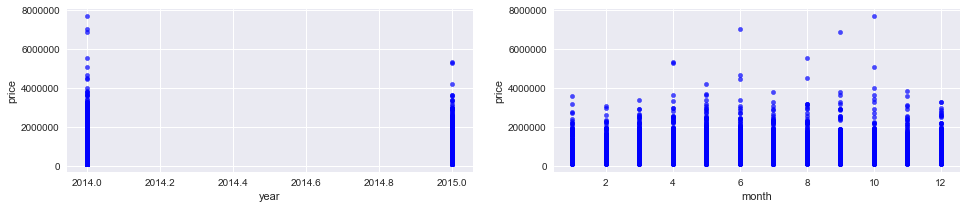

In [43]:
# create variables for each series you want to pass into the xcols list and compare them against one
y_sub = 'price'
date_sub = ['year','month']

def sub_scatter(xcols, y):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))
    for xcol, ax in zip(xcols, axes):
        df.plot(kind='scatter', x=xcol, y=y, ax=ax, alpha=0.7, color='b')

sub_scatter(date_sub, y_sub)

In [ ]:
# 1
# Visualize linearity with a pairplot (seaborn)
# Attempt to add a line of best fit and 95% confidence band. Aim to minimize sum of squared error.

#sns.pairplot(df, X, y, kind='reg')

def pairplot_loop(df=df, y='price', reg=True):
    for col in df:
        #col_corr = col.corr().abs()
        sns.pairplot(df, col, y, kind='reg')
        #if col_corr > 0.5:
            #print('Correlation coefficient is: {0}'.format(col_corr))
pairplot_loop(df, df.columns, y='price', reg=True)            
# sns.pairplot(df, X, y, kind='reg')

In [ ]:
#SEABORN
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

# Plots histogram and scatter (vs price) side by side
def plot_hist_scat_sns(df,target='price'):
    #plt.style.use('dark_background')

    
    ## ----------- DEFINE AESTHETIC CUSTOMIZATIONS ----------- ##
    # Axis Label fonts
    fontTitle = {'fontsize': 16,
               'fontweight': 'bold',
                'fontfamily':'serif'}

    fontAxis = {'fontsize': 14,
               'fontweight': 'bold',
                'fontfamily':'serif'}

    fontTicks = {'fontsize': 12,
               'fontweight':'bold',
                'fontfamily':'serif'}

    # Formatting dollar sign labels
    fmtPrice = '${x:,.0f}'
    tickPrice = mtick.StrMethodFormatter(fmtPrice)
    

    ## ----------- PLOTTING ----------- ##
    
    ## Loop through dataframe to plot
    for column in df.describe():
    
        # Create figure with subplots for current column
        # Note: in order to use identical syntax for large # of subplots (ax[i,j]), 
        #  declare an extra row of subplots to be removed later
        fig, ax = plt.subplots(figsize=(12,10), ncols=2, nrows=2)

        ## ----- SUBPLOT 1 -----##
        i,j = 0,0
        ax[i,j].set_title(column.capitalize(),fontdict=fontTitle)
        
        # Define graphing keyword dictionaries for distplot (Subplot 1)
        hist_kws = {"linewidth": 1, "alpha": 1, "color": 'blue','edgecolor':'w'}
        kde_kws = {"color": "white", "linewidth": 1, "label": "KDE"}
        
        # Plot distplot on ax[i,j] using hist_kws and kde_kws
        sns.distplot(df[column], norm_hist=True, kde=True,
                     hist_kws = hist_kws, kde_kws = kde_kws,
                     label=column+' histogram', ax=ax[i,j])
 

        # Set x axis label
        ax[i,j].set_xlabel(column.title(),fontdict=fontAxis)
    
        # Get x-ticks, rotate labels, and return
        xticklab1 = ax[i,j].get_xticklabels(which = 'both')
        ax[i,j].set_xticklabels(labels=xticklab1, fontdict=fontTicks, rotation=45)
        ax[i,j].xaxis.set_major_formatter(mtick.ScalarFormatter())

        
        # Set y-label 
        ax[i,j].set_ylabel('Density',fontdict=fontAxis)
        yticklab1=ax[i,j].get_yticklabels(which='both')
        ax[i,j].set_yticklabels(labels=yticklab1,fontdict=fontTicks)
        ax[i,j].yaxis.set_major_formatter(mtick.ScalarFormatter())
        
        
        # Set y-grid
        ax[i, j].set_axisbelow(True)
        ax[i, j].grid(axis='y',ls='--')

        
        ## ----- SUBPLOT 2-----  ##
        i,j = 0,1
        ax[i,j].set_title(column.capitalize(),fontdict=fontTitle)

        # Define the ketword dictionaries for  scatter plot and regression line (subplot 2)
        line_kws={"color":"white","alpha":0.5,"lw":4,"ls":":"}
        scatter_kws={'s': 2, 'alpha': 0.5,'marker':'.','color':'blue'}

        # Plot regplot on ax[i,j] using line_kws and scatter_kws
        sns.regplot(df[column], df[target], 
                    line_kws = line_kws,
                    scatter_kws = scatter_kws,
                    ax=ax[i,j])
        
        # Set x-axis label
        ax[i,j].set_xlabel(column.title(),fontdict=fontAxis)

         # Get x ticks, rotate labels, and return
        xticklab2=ax[i,j].get_xticklabels(which='both')
        ax[i,j].set_xticklabels(labels=xticklab2,fontdict=fontTicks, rotation=45)
        ax[i,j].xaxis.set_major_formatter(mtick.ScalarFormatter())

        # Set  y-axis label
        ax[i,j].set_ylabel('Price',fontdict=fontAxis)
        
        # Get, set, and format y-axis Price labels
        yticklab = ax[i,j].get_yticklabels()
        ax[i,j].set_yticklabels(yticklab,fontdict=fontTicks)
        ax[i,j].get_yaxis().set_major_formatter(tickPrice) 

        # Set y-grid
        ax[i, j].set_axisbelow(True)
        ax[i, j].grid(axis='y',ls='--')       
        
        ## ---------- Final layout adjustments ----------- ##
        # Deleted unused subplots 
        fig.delaxes(ax[1,1])
        fig.delaxes(ax[1,0])

        # Optimizing spatial layout
        fig.tight_layout()
        figtitle=column+'_dist_regr_plots.png'
        #plt.savefig(fig_filepath+figtitle)
    return

In [ ]:
# Side by side plot of Histograms and Scatterplots for each variable vs price:

fig = plot_hist_scat_sns(df,target='price')

## Outliers

In [ ]:
# Tukey's method using IQR to eliminate 
def detect_outliers(df, n, features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
        outlier_indices = Counter(outlier_indices)        
        multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        return multiple_outliers 
# Outliers_to_drop = detect_outliers(data,2,["col1","col2"])
# df.loc[Outliers_to_drop] # Show the outliers rows
# Drop outliers
# data= data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [ ]:
features = df.columns
#['condition', 'grade','zipcode','sqft_living', 'bathrooms']
outliers_to_drop = detect_outliers(df, 2, features)
df.loc[outliers_to_drop]


In [ ]:
outliers_to_drop

# FIT AN INITIAL MODEL:
Various forms, detail later...
Assessing the model:
Assess parameters (slope,intercept)
Check if the model explains the variation in the data (RMSE, F, R_square)
Are the coeffs, slopes, intercepts in appropriate units?
Whats the impact of collinearity? Can we ignore?
Revise the fitted model
Multicollinearity is big issue for lin regression and cannot fully remove it
Use the predictive ability of model to test it (like R2 and RMSE)
Check for missed non-linearity
Holdout validation / Train/test split
use sklearn train_test_split

In [ ]:
# Plots histogram and scatter (vs price) side by side
def plot_hist_scat(df,target='price',stats=False):
#     plt.style.use('bmh')
    plt.style.use('fivethirtyeight')
    
#     fontTitle = {'family': 'serif',
#             'color':  'black',
#             'weight': 'normal',
#             'size': 16,
#             }
#     fontTicks = {'family': 'sans-serif',
#             'color':  'black',
#             'weight': 'normal',
#             'size': 10,
#             }
    results = [['column','K_square','p-val']]

    for column in df.describe():

        fig = plt.figure(figsize=(8,3) )#plt.figaspect(0.5))#(5,4))
        
        ax1 = fig.add_subplot(121)
        ax1.hist(df[column],density=True,label = column+' histogram',bins=20)
        ax1.set_title(column.capitalize())

        ax1.legend()
        
        ax2 = fig.add_subplot(122)
        ax2.scatter(x=df[column], y=df[target],label = column+' vs price',marker='.')
        ax2.set_title(column.capitalize())
        ax2.legend()

        fig.tight_layout()
        if stats==True:
            stat, p = normtest(df[column])
#             print(f'Normality test for {column}:K_square = {stat}, p-value = {p}')

            results.append([column,stat, p])
    return pd.DataFrame(results)

In [ ]:
# 2
# SK Learn - X is a feature matrix in Pandas Dataframe.
# Y is a response vector (Pandas series)
# Separate variables

feature_cols = ['sqft_living','condition','zipcode']
X = df[feature_cols]
y = df['price']

In [ ]:
# 3
# Splitting X & y into training and testing sets
# By passing X and y variables into the train_test_split method,
# we can capture the splits in data by assigning 4 variables to the result:

# Import SK Learn train test split
import sklearn
from sklearn.cross_validation import train_test_split

# Assign variables to capture train test split output
X_train, X_test, y_train, y_test = train_test_split(X, y)



In [ ]:
# 4 Train the model

# Import sklearn.linear_model to access LinearRegression 
from sklearn.linear_model import LinearRegression

# instantiate and model fit to training data
linreg = LinearRegression()

# fit model to training data (learn coefficients)
linreg.fit(X_train, y_train)

In [ ]:
# 5
# Interpreting Coefficients
# The coefficients will allow us to model our equation with values for our beta's. 
# The linreg variable (assigned to a LinearRegression object) extracts the intercept and coefficients

# Print y-intercept
print(linreg.intercept_)

# Print beta coefficients in same order as passed
print(linreg.coef_)

# Pair the feature names and coeffiecients together
zip(feature_cols, linreg.coef_)

# The intercept is the B0 value; 
# Each coef is corresponding Beta for the X's passed in, respective order


In [ ]:
# 6 
# Making predictions based on the model:
# Pass the predict method to test data
# Return prediced values of y given new test X data

y_pred = linreg.predict(X_test)

In [ ]:
# 7 
# Primary metrics for evaluating linear models:
# Mean absolute error (MAE) : easiest to understand, represents average error
# Mean Squared Error (MSE) : similar to MAE but noise is exaggerated and larger errors are "punished"
# Root mean squared error (RMSE) : similar to MSE but easier to interpret bc uses base units. Primary metric*

# Each of the above requires two lists as parameters: predicted values and true values

# Import metrics library
from sklearn import metrics

# Print result of MAE:
print(metrics.mean_absolute_error(y_test, y_pred))

# Print resultof MSE:
print(metrics.mean_squared_error(y_true, y_pred))

# Print result of RMSE:
print(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))


In [ ]:
# 8
# Feature Selection
# Note which X's have minimal impact on y. Remove these to make model more accurate

# Replace feature_cols & X
# Train_test_split data
# Fit model to linreg again using linreg.fit
# Make predictions using (y_pred = linreg.predict(X_test))
# Compute RMSE
# Repeat until RMSE satisfactory

In [ ]:
# Choose a linear model by forward selection
# The function below optimizes adjusted R-squared by adding features that help the most one at a time
# until the score goes down or you run out of features.

import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
model = forward_selected(df, 'price')
print(model.model.formula)
print(model.rsquared_adj)


Explaining/Phrasing R-Squared values
An obtained R-squared value of say 0.85 can be put into a statement as

85% of the variations in dependent variable  𝑦  are explained by the independent variable in our model.

# Visualizations

##### TABLEAU HOW TO (temp)
Short how-to plot geo data in Tableau:
Load in your .csv dataset from your project.
Let it use data interpreter. It should identify zipcode as a location.
On your worksheet page:
For plotting each price for each house:
Drag the Measures Lat and Long onto the rows and columns boxes (top of sheet)
Drag the Measure price onto the Color Button under Marks.
It should now be listed at the bottom of the Marks panel.
Right-click and select "Dimension"
For plotting median income by zipcode:
Drag zipcode form the Dimensions panel onto the main graph window.
It will automatically load in map of location.
Drag price onto the color button (it will now appear in the Marks window)
Rich click on Price. Select "Measure" > Median
Customize map features by selecting "Map" > Map Layers on the Menu Bar.


In [ ]:
# https://www.youtube.com/watch?v=upBvuTqOy9k&feature=youtu.be

import plotly
plotly.offline.init_notebook_mode(connected=True)

import pandas as pd
import numpy as np

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [ ]:
data = go.Scatter(x=[1,2,3,4], y=[3,6,8,9], name='Blue')
layout = go.Layout(title='Random Scatter')

fig = go.Figure(data=data, layout=layout)

* "how did you pick the question(s) that you did?"
* "why are these questions important from a business perspective?"
* "how did you decide on the data cleaning options you performed?"
* "why did you choose a given method or library?"
* "why did you select those visualizations and what did you learn from each of them?"
* "why did you pick those features as predictors?"
* "how would you interpret the results?"
* "how confident are you in the predictive quality of the results?"
* "what are some of the things that could cause the results to be wrong?"